In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch as th
import torch.nn as nn
import torchvision.transforms as T

from captum.attr import DeepLift, IntegratedGradients, NoiseTunnel, GradientShap
from captum.metrics import sensitivity_max

from pytorch_lightning import Trainer
from skimage.segmentation import slic
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

from tint.attr import BayesMask, GeodesicIntegratedGradients
from tint.attr.models import BayesMaskNet
from tint.metrics import accuracy, comprehensiveness, cross_entropy, sufficiency, lipschitz_max
from tint.models import CNN, MLP

from experiments.mnist.classifier import MnistClassifierNet

In [2]:
# Get data transform
transform = T.Compose([T.ToTensor(), T.Normalize((0.1307,), (0.3081,))])

# Load train and test data
mnist_train = MNIST(
    root="../tint/data/mnist",
    train=True,
    transform=transform,
    download=True,
)
mnist_train_loader = DataLoader(mnist_train, batch_size=32, shuffle=True)

mnist_test = MNIST(
    root="../tint/data/mnist",
    train=False,
    transform=transform,
    download=True,
)
mnist_test_loader = DataLoader(mnist_test, batch_size=32, shuffle=False)

# Create classifier
classifier = MnistClassifierNet(
    loss="cross_entropy",
    lr=0.0001,
    l2=1e-3,
)

# Load pre-trained
classifier = classifier.load_from_checkpoint(
    "lightning_logs/version_315890482023588399852655265675874543358/checkpoints/epoch=9-step=18750.ckpt"
)


# Switch to eval
classifier.eval()

MnistClassifierNet(
  (net): MnistClassifier(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (dropout1): Dropout(p=0.25, inplace=False)
    (dropout2): Dropout(p=0.5, inplace=False)
    (fc1): Linear(in_features=9216, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=10, bias=True)
  )
  (_loss): MSELoss()
  (train_acc): Accuracy()
  (val_acc): Accuracy()
  (test_acc): Accuracy()
)

In [3]:
# Get data, labels and compute segmentation for 1000 test images
# using the slic function from scikit-image.
mnist_test_loader = DataLoader(mnist_test, batch_size=1, shuffle=True)

x_test = list()
y_test = list()
seg_test = list()
for i, (x, y) in enumerate(mnist_test_loader):
    if i == 1000:
        break

    sample = np.squeeze(x.numpy().astype("double"), axis=0)
    segments = slic(
        sample.reshape(28, 28, 1),
        n_segments=20,
        compactness=1,
        sigma=0.1,
    ).reshape(1, 28, 28)
    x_test.append(th.from_numpy(sample))
    y_test.append(y[0])
    seg_test.append(th.from_numpy(segments) - 1)

x_test = th.stack(x_test).float()
y_test = th.stack(y_test).long()
seg_test = th.stack(seg_test)

# Get train data for LOF and AugmentedOcclusion methods
x_train = list()
y_train = list()
for data, label in mnist_train_loader:
    x_train.append(data)
    y_train.append(label)
x_train = th.cat(x_train)
y_train = th.cat(y_train).long()

In [4]:
attr = dict()

In [5]:
baselines = -0.4242

In [10]:
trainer = Trainer(
    max_epochs=100,
    accelerator="cpu",
)
mask = BayesMaskNet(
    forward_func=classifier,
    distribution="none",
    model=nn.Conv2d(1, 1, 3, padding=1),
    hard=False,
    comp_loss=True,
    optim="adam",
    lr=0.01,
)
explainer = BayesMask(classifier)
_attr = explainer.attribute(
    x_test,
    baselines=baselines,
    target=y_test,
    trainer=trainer,
    mask_net=mask,
    batch_size=64,
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | net   | BayesMask | 784 K 
1 | _loss | MSELoss   | 0     
------------------------------------
784 K     Trainable params
0         Non-trainable params
784 K     Total params
3.136     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/Users/joseph.enguehard/opt/miniconda3/envs/tint/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:657: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [9]:
accuracy(
    classifier,
    x_test,
    attributions=_attr,
    baselines=baselines,
    topk=0.05,
    mask_largest=False,
)

0.5189999938011169

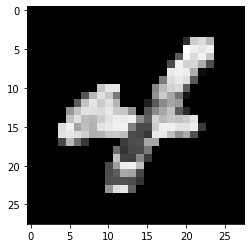

In [18]:
plt.imshow(_attr[2][0].detach().numpy(), cmap='gray')
plt.show()

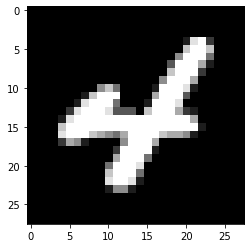

In [19]:
plt.imshow(x_test[2][0].detach().numpy(), cmap='gray')
plt.show()

In [1]:
import matplotlib.pyplot as plt
import torch as th

from captum.attr import DeepLift, GradientShap, IntegratedGradients, NoiseTunnel
from matplotlib.colors import ListedColormap
from pytorch_lightning import Trainer
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

from tint.attr import GeodesicIntegratedGradients
from tint.models import MLP, Net

/Users/joseph.enguehard/opt/miniconda3/envs/tint/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
x, y = make_moons(n_samples=10000, noise=0.15, random_state=12)

In [3]:
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [4]:
x_train = th.from_numpy(x_train).float()
x_test = th.from_numpy(x_test).float()
y_train = th.from_numpy(y_train).long()
y_test = th.from_numpy(y_test).long()

In [5]:
train = TensorDataset(x_train, y_train)
test = TensorDataset(x_test, y_test)

In [6]:
train_loader = DataLoader(train, batch_size=32, shuffle=True)
test_loader = DataLoader(test, batch_size=32, shuffle=False)

In [7]:
net = Net(MLP(units=[2, 10, 10, 2], activation_final="log_softmax"), loss="nll")

In [8]:
net

Net(
  (net): MLP(
    (mlp): Sequential(
      (Linear_0): Linear(in_features=2, out_features=10, bias=True)
      (ReLU_0): ReLU()
      (Linear_1): Linear(in_features=10, out_features=10, bias=True)
      (ReLU_1): ReLU()
      (Linear_2): Linear(in_features=10, out_features=2, bias=True)
      (LogSoftmax_2): LogSoftmax(dim=-1)
    )
  )
  (_loss): NLLLoss()
)

In [9]:
trainer = Trainer(max_epochs=50)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/joseph.enguehard/opt/miniconda3/envs/tint/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1788: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [10]:
trainer.fit(net, train_loader)

/Users/joseph.enguehard/opt/miniconda3/envs/tint/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:117: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name  | Type    | Params
----------------------------------
0 | net   | MLP     | 162   
1 | _loss | NLLLoss | 0     
----------------------------------
162       Trainable params
0         Non-trainable params
162       Total params
0.001     Total estimated model params size (MB)
/Users/joseph.enguehard/opt/miniconda3/envs/tint/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

In [11]:
pred = trainer.predict(net, test_loader)

/Users/joseph.enguehard/opt/miniconda3/envs/tint/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 235it [00:00, ?it/s]

In [12]:
(th.cat(pred).argmax(-1) == y_test).float().mean()

tensor(0.9896)

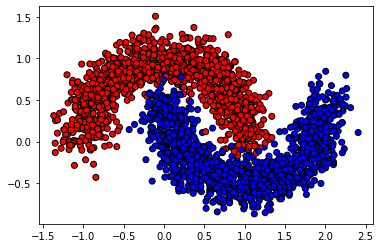

In [13]:
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap=cm_bright, edgecolors="k")

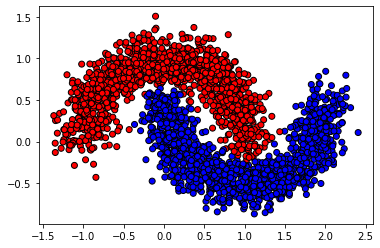

In [14]:
plt.scatter(x_test[:, 0], x_test[:, 1], c=th.cat(pred).argmax(-1), cmap=cm_bright, edgecolors="k")

In [15]:
ig = IntegratedGradients(net)

In [16]:
baselines = th.zeros_like(x_test)
baselines[:, 0] = 0.
baselines[:, 1] = 0.5

/Users/joseph.enguehard/opt/miniconda3/envs/tint/lib/python3.9/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 2500 equal to the number of examples.
  warnings.warn(


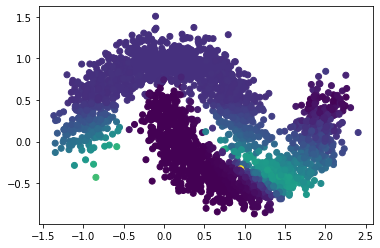

In [17]:
attr_ig = ig.attribute(
    x_test, 
    target=y_test, 
    baselines=baselines, 
    internal_batch_size=200,
)

plt.scatter(x_test[:, 0], x_test[:, 1], c=attr_ig.abs().sum(-1))

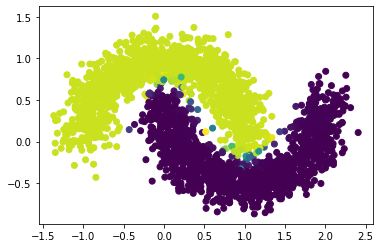

In [18]:
gig = GeodesicIntegratedGradients(net)

attr_gig = th.zeros_like(x_test)
for target in range(2):
    attr_gig[y_test == target] = gig.attribute(
        x_test[y_test == target], 
        target=target,
        baselines=baselines[y_test == target],
        n_neighbors=5,
        internal_batch_size=200,
    ).float()

plt.scatter(x_test[:, 0], x_test[:, 1], c=attr_gig.abs().sum(-1))

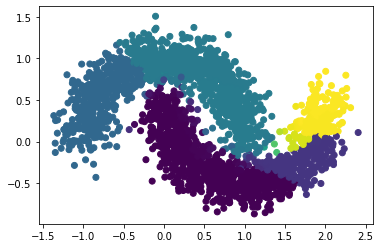

In [19]:
attr_enh = th.zeros_like(x_test)
for target in range(2):
    attr_enh[y_test == target] = gig.attribute(
        x_test[y_test == target], 
        target=target,
        baselines=baselines[y_test == target],
        n_neighbors=5,
        internal_batch_size=200,
        distance="euclidean",
    ).float()

plt.scatter(x_test[:, 0], x_test[:, 1], c=attr_enh.abs().sum(-1))

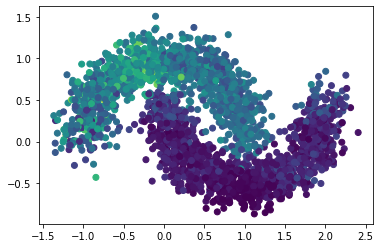

In [20]:
from captum.attr import GradientShap

gs = GradientShap(net)
attr_gs = th.zeros_like(x_test)

for target in range(2):
    attr_gs[y_test == target] = gs.attribute(
        x_test[y_test == target], 
        target=target, 
        baselines=x_test[y_test == 1],
        n_samples=50,
    )

plt.scatter(x_test[:, 0], x_test[:, 1], c=attr_gs.abs().sum(-1))

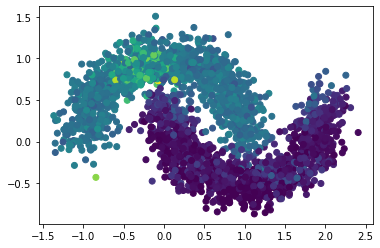

In [21]:
nt = NoiseTunnel(IntegratedGradients(net))
attr_nt = nt.attribute(
    x_test,
    baselines=x_test[y_test == 1],  # We sample baselines only from one moon
    target=y_test,
    internal_batch_size=25000,
    nt_samples=10,
    stdevs=0.1,
    draw_baseline_from_distrib=True,
)
plt.scatter(x_test[:, 0], x_test[:, 1], c=attr_nt.abs().sum(-1))

In [22]:
for _attr in [attr_ig, attr_gs, attr_nt, attr_enh, attr_gig]:
    _attr = _attr.abs().sum(-1)

    topk_idx = th.topk(
        _attr,
        int(len(_attr) * 0.5),
        sorted=False,
        largest=False,
    ).indices

    print(th.cat(pred).argmax(-1)[topk_idx].float().mean())

tensor(0.6488)
tensor(0.9408)
tensor(0.9632)
tensor(0.8384)
tensor(0.9808)


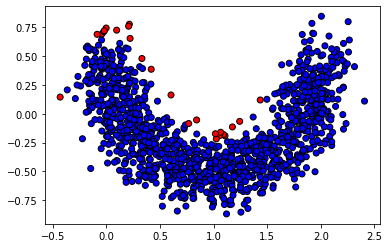

In [23]:
plt.scatter(
    x_test[:, 0][topk_idx], 
    x_test[:, 1][topk_idx], 
    c=th.cat(pred).argmax(-1)[topk_idx], 
    cmap=cm_bright,
    edgecolors="k",
)

In [1]:
import numpy as np
import torch as th

from os import path


import matplotlib.pyplot as plt

from pytorch_lightning import Trainer
from tqdm.notebook import tqdm

#scikit-learn related imports
import sklearn
from sklearn.datasets import make_classification, fetch_covtype
from sklearn.model_selection import train_test_split

# pytorch relates imports
import torch
import torch.nn as nn
import torch.optim as optim

# imports from captum library
from captum.attr import (
    IntegratedGradients, 
    DeepLift, 
    GradientShap, 
    NoiseTunnel, 
    FeatureAblation, 
    InputXGradient, 
    Lime,
    KernelShap,
    Saliency,
)

from tint.attr import GeodesicIntegratedGradients
from tint.models import Net, MLP

In [2]:
covtype = fetch_covtype()
X, y = covtype["data"], covtype["target"]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [4]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).long() - 1

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).long() - 1

In [5]:
mean = X_train.mean(0, keepdim=True)
std = X_train.std(0, keepdim=True)

X_train = (X_train - mean) / (std + 1e-7)
X_test = (X_test - mean) / (std + 1e-7)

In [6]:
datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=10, shuffle=True)

In [7]:
classifier = Net(MLP([54, 100, 50, 10, 7]), lr=0.001, loss="cross_entropy")

In [8]:
trainer = Trainer(max_steps=20000)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/joseph.enguehard/opt/miniconda3/envs/tint/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1788: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [9]:
trainer.fit(classifier, train_dataloaders=train_iter)

/Users/joseph.enguehard/opt/miniconda3/envs/tint/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:117: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name  | Type             | Params
-------------------------------------------
0 | net   | MLP              | 11.1 K
1 | _loss | CrossEntropyLoss | 0     
-------------------------------------------
11.1 K    Trainable params
0         Non-trainable params
11.1 K    Total params
0.045     Total estimated model params size (MB)
/Users/joseph.enguehard/opt/miniconda3/envs/tint/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  ra

Training: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

In [10]:
classifier.eval()
outputs = classifier(X_test)

acc = (outputs.argmax(-1) == y_test).float().mean()
print("acc: ", acc)

acc:  tensor(0.7757)


In [11]:
X_test = X_test[:1000]
y_test = y_test[:1000]

In [12]:
ig = IntegratedGradients(classifier)
ixg = InputXGradient(classifier)
gs = GradientShap(classifier)
fa = FeatureAblation(classifier)
sa = Saliency(classifier)


ig_attr_test = ig.attribute(X_test, n_steps=50, target=y_test)
ixg_attr_test = ixg.attribute(X_test, target=y_test)
gs_attr_test = gs.attribute(X_test, X_train, target=y_test, n_samples=50, stdevs=.5)
fa_attr_test = fa.attribute(X_test, target=y_test)
sa_attr_test = sa.attribute(X_test, target=y_test)

/Users/joseph.enguehard/opt/miniconda3/envs/tint/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [13]:
nt = NoiseTunnel(Saliency(classifier))
nt_attr_test = nt.attribute(
    X_test, 
    #baselines=X_train, 
    target=y_test, 
    nt_samples=50, 
    #n_steps=5, 
    stdevs=.1,
    #draw_baseline_from_distrib=True,
)

KeyboardInterrupt: 

In [67]:
nt = NoiseTunnel(IntegratedGradients(classifier))
_nt_attr_test = nt.attribute(
    X_test, 
    baselines=X_train,
    target=y_test,
    nt_samples=50,
    n_steps=5,
    stdevs=.5,
    draw_baseline_from_distrib=True,
    nt_type="smoothgrad_sq",
)

In [19]:
gig_attr_test = list()

for x, y in tqdm(zip(X_test, y_test), total=len(X_test)):
    _attr = list()
    for _ in range(50):
        std = th.ones(x.shape) * .5
        _x = x + th.normal(0, std)

        rand = th.rand((50,) + x.shape).sort(dim=0).values
        # rand = (th.arange(6) / 5.).unsqueeze(-1)
        # rand = (th.arange(1, 51) / 50.).unsqueeze(-1) * (th.rand(54)).unsqueeze(0)
        # rand = th.rand(6).unsqueeze(-1)
        # rand = (
        #    (th.arange(1, n) / n).repeat_interleave(10).unsqueeze(-1) + 
        #    (2 * th.rand((10 * (n -1),) + x.shape) - 1) * (1 / (10 * n))
        #)
        
        # baseline = X_train[y_train == y].mean(0, keepdim=True)
        baselines = X_train[th.randint(len(X_train), (1,)).item()]
        # baselines = 0
        
        x_aug = (_x - baselines).unsqueeze(0) * rand + baselines.unsqueeze(0)
        # x_aug = X_train[th.randint(len(X_train), (100,))]

        gig = GeodesicIntegratedGradients(classifier, data=x_aug, n_neighbors=15)

        _attr.append(
            gig.attribute(
                _x.unsqueeze(0),
                baselines=baselines.unsqueeze(0),
                target=y,
                n_steps=1,
                internal_batch_size=200,
            )
        )
    gig_attr_test.append(_attr)

# gig_paths = [[y[1] for y in x] for x in gig_attr_test]
# gig_grads = [[y[2] for y in x] for x in gig_attr_test]
# gig_graphs = [[y[3] for y in x] for x in gig_attr_test]
# gig_attr_test = [[y[0] for y in x] for x in gig_attr_test]
gig_attr_test = [th.cat(x) for x in gig_attr_test]
gig_attr_test = [x.mean(0) for x in gig_attr_test]
gig_attr_test = th.stack(gig_attr_test)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [20]:
enh_attr_test = list()

for x, y in tqdm(zip(X_test, y_test), total=len(X_test)):
    _attr = list()
    for _ in range(50):
        std = th.ones(x.shape) * .5
        _x = x + th.normal(0, std)

        rand = th.rand((50,) + x.shape).sort(dim=0).values
        # rand = (th.arange(6) / 5.).unsqueeze(-1)
        # rand = th.rand(6).unsqueeze(-1)
        # rand = (
        #    (th.arange(1, n) / n).repeat_interleave(10).unsqueeze(-1) + 
        #    (2 * th.rand((10 * (n -1),) + x.shape) - 1) * (1 / (2 * n))
        #)
        
        # baseline = X_train[y_train == y].mean(0, keepdim=True)
        baselines = X_train[th.randint(len(X_train), (1,)).item()]
        # baselines = 0
        
        x_aug = (_x - baselines).unsqueeze(0) * rand + baselines.unsqueeze(0)
        # x_aug = X_train[y_train == y][:100]

        gig = GeodesicIntegratedGradients(classifier, data=x_aug, n_neighbors=15)
    
        _attr.append(
            gig.attribute(
                _x.unsqueeze(0),
                baselines=baselines.unsqueeze(0),
                target=y,
                n_steps=1,
                internal_batch_size=200,
                distance="euclidean",
            )
        )
    enh_attr_test.append(_attr)

# enh_paths = [[y[1] for y in x] for x in enh_attr_test]
# enh_grads = [[y[2] for y in x] for x in enh_attr_test]
# enh_graphs = [[y[3] for y in x] for x in enh_attr_test]
# enh_attr_test = [[y[0] for y in x] for x in enh_attr_test]
enh_attr_test = [th.cat(x) for x in enh_attr_test]
enh_attr_test = [x.mean(0) for x in enh_attr_test]
enh_attr_test = th.stack(enh_attr_test)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [226]:
_gig_attr_test = list()

for x, y in tqdm(zip(X_test, y_test), total=len(X_test)):
    _attr = list()

    rand = th.rand((50,) + x.shape).sort(dim=0).values
    
    x_aug = x.unsqueeze(0) * rand

    gig = GeodesicIntegratedGradients(classifier, data=x_aug, n_neighbors=15)

    _gig_attr_test.append(
        gig.attribute(
            x.unsqueeze(0),
            target=y,
            n_steps=5,
            internal_batch_size=200,
        )
    )
_gig_attr_test = th.cat(_gig_attr_test)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [227]:
_enh_attr_test = list()

for x, y in tqdm(zip(X_test, y_test), total=len(X_test)):
    _attr = list()

    rand = th.rand((50,) + x.shape).sort(dim=0).values
    
    x_aug = x.unsqueeze(0) * rand

    gig = GeodesicIntegratedGradients(classifier, data=x_aug, n_neighbors=15)

    _enh_attr_test.append(
        gig.attribute(
            x.unsqueeze(0),
            target=y,
            n_steps=5,
            internal_batch_size=200,
            distance="euclidean",
        )
    )
_enh_attr_test = th.cat(_enh_attr_test)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [23]:
from pytorch_lightning import Trainer
from tint.attr import ExtremalMask
from tint.attr.models import ExtremalMaskNet


trainer = Trainer(
    max_epochs=2000,
    accelerator="cpu",
)
mask = ExtremalMaskNet(
    forward_func=classifier,
    # model=MLP([20, 10, 20]),
    comp_loss=True,
    loss="mse",
    optim="adam",
    lr=0.01,
)
explainer = ExtremalMask(classifier)
em_attr_test = explainer.attribute(
    X_test,
    target=y_test,
    trainer=trainer,
    mask_net=mask,
    batch_size=100,
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/joseph.enguehard/opt/miniconda3/envs/tint/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1788: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/joseph.enguehard/opt/miniconda3/envs/tint/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:117: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name  | Type         | Params
---------------------------------------
0 | net   | ExtremalMask | 54.0 K
1 | _loss | MSELoss      | 0     
---------------------------------------
54.0 K    Trainable params
0         Non-trainable params
54.0 K    Total params
0.216     Total estimated model params size (MB)
/Users/joseph.enguehar

Training: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

In [24]:
rand_attr_test = th.rand_like(X_test)

In [ ]:
from tint.metrics import accuracy, comprehensiveness, cross_entropy, log_odds, sufficiency
from tint.metrics.weights import lime_weights

x_avg = X_train

names = {
    0: "SA",
    1: "IG",
    2: "IXG",
    #2: "GS",
    #3: "FA",
    #2: "NT",
    #2: "NT_SQ",
    #5: "NT_GIG",
    #6: "BM",
    #7: "NT_ENH",
    #2: "GIG",
    #3: "ENH",
    #4: "RAND",
    #5: "LIME",
    #6: "SHAP",
}

acc_comp = dict()
acc_suff = dict()
comp = dict()
ce_comp = dict()
ce_suff = dict()
l_odds = dict()
suff = dict()

for i, v in enumerate([
    sa_attr_test,
    ig_attr_test, 
    ixg_attr_test, 
    #gs_attr_test,
    #fa_attr_test,
    #nt_attr_test,
    #_nt_attr_test,
    #gig_attr_test,
    #em_attr_test,
    #enh_attr_test,
    #_gig_attr_test,
    #_enh_attr_test,
    #rand_attr_test,
    #lime_attr_test,
    #shap_attr_test,
]):
    acc_comp[names[i]] = list()
    acc_suff[names[i]] = list()
    comp[names[i]] = list()
    ce_comp[names[i]] = list()
    ce_suff[names[i]] = list()
    l_odds[names[i]] = list()
    suff[names[i]] = list()
    
    #for topk in tqdm([0.02, 0.05, 0.1, 0.2, 0.5, 0.9], leave=False, desc=names[i]):
    for topk in tqdm(range(1, 54), leave=False, desc=names[i]):
        topk /= 54.
        acc_comp[names[i]].append(
            accuracy(
                classifier,
                X_test,
                attributions=v.cpu().abs(),
                baselines=x_avg,
                #target=y_test,
                n_samples=50,
                n_samples_batch_size=6,
                stdevs=.1,
                draw_baseline_from_distrib=True,
                topk=topk,
                weight_fn=lime_weights("euclidean"),
                mask_largest=True,
            )
        )
        acc_suff[names[i]].append(
            accuracy(
                classifier,
                X_test,
                attributions=v.cpu().abs(),
                baselines=x_avg,
                #target=y_test,
                n_samples=50,
                stdevs=.1,
                draw_baseline_from_distrib=True,
                topk=topk,
                mask_largest=False,
            )
        )
        comp[names[i]].append(
            comprehensiveness(
                classifier,
                X_test,
                attributions=v.cpu().abs(),
                baselines=x_avg,
                #target=y_test,
                n_samples=50,
                stdevs=.1,
                draw_baseline_from_distrib=True,
                topk=topk,
            )
        )
        ce_comp[names[i]].append(
            cross_entropy(
                classifier,
                X_test,
                attributions=v.cpu().abs(),
                baselines=x_avg,
                #target=y_test,
                n_samples=50,
                stdevs=.1,
                draw_baseline_from_distrib=True,
                topk=topk,
                mask_largest=True,
            )
        )
        ce_suff[names[i]].append(
            cross_entropy(
                classifier,
                X_test,
                attributions=v.cpu().abs(),
                baselines=x_avg,
                #target=y_test,
                n_samples=50,
                stdevs=.1,
                draw_baseline_from_distrib=True,
                topk=topk,
                mask_largest=False,
            )
        )
        l_odds[names[i]].append(
            log_odds(
                classifier,
                X_test,
                attributions=v.cpu().abs(),
                baselines=x_avg,
                #target=y_test,
                n_samples=50,
                stdevs=.1,
                draw_baseline_from_distrib=True,
                topk=topk,
            )
        )
        suff[names[i]].append(
            sufficiency(
                classifier,
                X_test,
                attributions=v.cpu().abs(),
                baselines=x_avg,
                #target=y_test,
                n_samples=50,
                stdevs=.1,
                draw_baseline_from_distrib=True,
                topk=topk,
            )
        )

SA:   0%|          | 0/53 [00:00<?, ?it/s]

> /Users/joseph.enguehard/Documents/Python/time_interpret/tint/metrics/base.py(188)_base_metric()
    186 
    187     # If weight_fn provided return a weighted average
--> 188     if weight_fn:
    189         weights = torch.cat(weights)
    190         weights = weights.to(out.device)

ipdb> out.shape
*** AttributeError: 'list' object has no attribute 'shape'
ipdb> len(out)
9
ipdb> out[0].shape
torch.Size([6000, 1])
ipdb> out[-1].shape
torch.Size([2000, 1])


In [21]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 8)

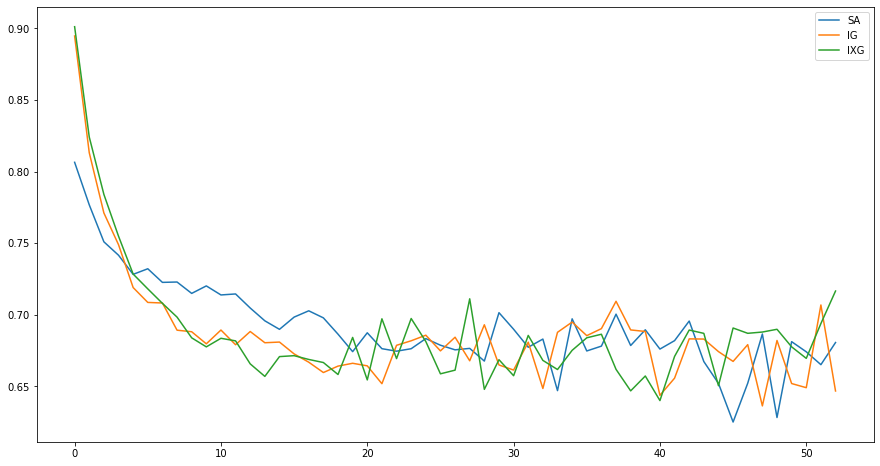

In [22]:
for k, v in acc_comp.items():
    plt.plot(v, label=k)
plt.legend()
plt.show()

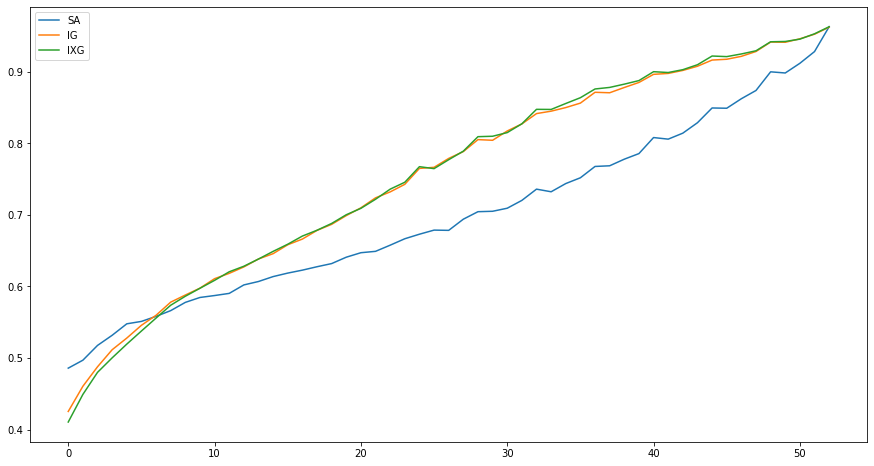

In [23]:
for k, v in acc_suff.items():
    plt.plot(v, label=k)
plt.legend()
plt.show()

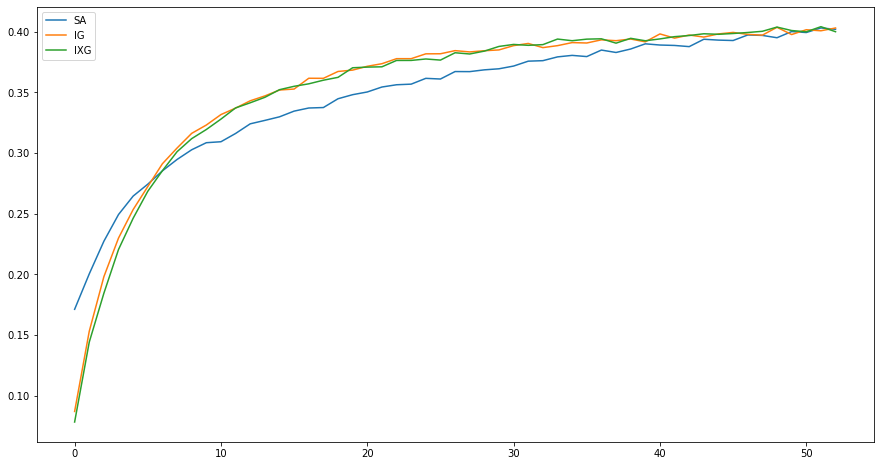

In [24]:
for k, v in comp.items():
    plt.plot(v, label=k)
plt.legend()
plt.show()

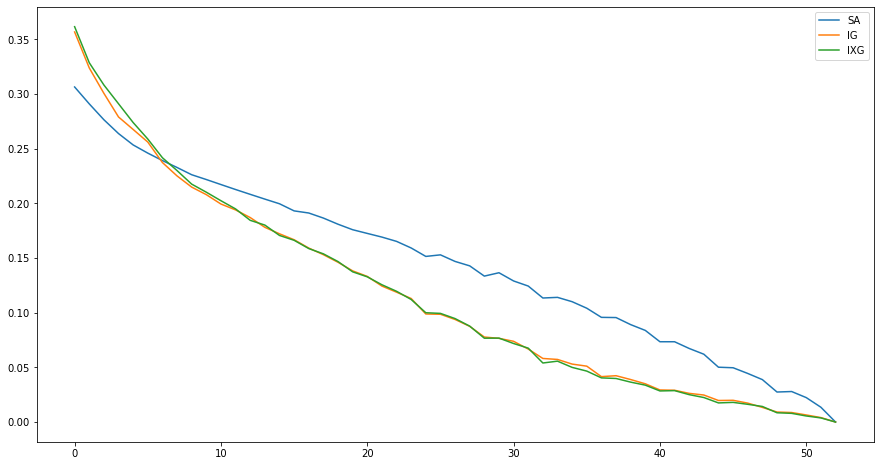

In [25]:
for k, v in suff.items():
    plt.plot(v, label=k)
plt.legend()
plt.show()

In [401]:
true_saliency = th.zeros_like(X_test)
true_saliency[:, :10] = 1.

In [402]:
from tint.metrics.white_box import aup, aur, roc_auc, auprc

In [404]:
names = {
    0: "IG",
    1: "IXG",
    2: "GS",
    3: "FA",
    4: "NT",
    5: "NT_GIG",
    6: "BM",
    7: "NT_ENH",
    8: "GIG",
    9: "ENH",
    10: "RAND",
}

for metric in [aup, aur, roc_auc, auprc]:
    for i, v in enumerate([
        ig_attr_test, 
        ixg_attr_test, 
        gs_attr_test,
        fa_attr_test,
        nt_attr_test,
        gig_attr_test,
        em_attr_test,
        enh_attr_test,
        _gig_attr_test,
        _enh_attr_test,
        rand_attr_test,
    ]):
        print(metric.__name__, names[i], metric(v, true_saliency))
    print()

aup IG 0.6612673609821372
aup IXG 0.6469645764679212
aup GS 0.7143564588804701
aup FA 0.6963076081433505
aup NT 0.7212515648767851
aup NT_GIG 0.7147937837735315
aup BM 0.7233795958850828
aup NT_ENH 0.7217082939634161
aup GIG 0.6573221754862383
aup ENH 0.6747823317364038
aup RAND 0.4958232526545671

aur IG 0.41956251883002044
aur IXG 0.420306956476305
aur GS 0.4325769278990832
aur FA 0.40108707024773393
aur NT 0.42408601667861406
aur NT_GIG 0.4251992131868203
aur BM 0.34116891205706146
aur NT_ENH 0.4223923553430285
aur GIG 0.4660177630241853
aur ENH 0.4663774678525407
aur RAND 0.49740420336648455

roc_auc IG 0.561808135
roc_auc IXG 0.5555850150000001
roc_auc GS 0.57819541
roc_auc FA 0.588239285
roc_auc NT 0.576137565
roc_auc NT_GIG 0.574322305
roc_auc BM 0.6280157250000001
roc_auc NT_ENH 0.57772259
roc_auc GIG 0.57060802
roc_auc ENH 0.5742092050000001
roc_auc RAND 0.49655509

auprc IG 0.6244432021540285
auprc IXG 0.6130051053555533
auprc GS 0.6685196577642277
auprc FA 0.6470102818828762

In [1]:
import pandas as pd

In [84]:
df = pd.read_csv("../experiments/moons/results.csv")

In [85]:
df1 = df[df["Activations"] == "relu"]
df2 = df[df["Activations"] == "softplus"]

In [126]:
_df1 = df1[df1["Noise"] == 0.05]

In [127]:
for explainer in df.Explainer.unique():
    print(explainer, f"{_df1[_df1['Explainer'] == explainer]['Purity'].mean():.4f}")

acc 0.9908
deep_lift 0.8978
geodesic_integrated_gradients_5 0.9425
geodesic_integrated_gradients_10 0.9418
geodesic_integrated_gradients_15 0.9455
enhanced_integrated_gradients_5 0.9127
enhanced_integrated_gradients_10 0.8911
enhanced_integrated_gradients_15 0.8896
gradient_shap 0.8914
integrated_gradients 0.8758
smooth_grad 0.8963


In [128]:
_df2 = df2[df2["Noise"] == 0.05]

In [129]:
for explainer in df.Explainer.unique():
    print(explainer, f"{_df2[_df2['Explainer'] == explainer]['Purity'].mean():.4f}")

acc 1.0000
deep_lift 0.9354
geodesic_integrated_gradients_5 0.9306
geodesic_integrated_gradients_10 0.9322
geodesic_integrated_gradients_15 0.9318
enhanced_integrated_gradients_5 0.9280
enhanced_integrated_gradients_10 0.9245
enhanced_integrated_gradients_15 0.9223
gradient_shap 0.8992
integrated_gradients 0.8735
smooth_grad 0.8997


In [131]:
from tint.models import Bert

tokenizer, model = Bert(
    pretrained_model_name_or_path="textattack/bert-base-uncased-SST-2",
)

In [133]:
tokenizer.pad_token_id

0

In [143]:
import torch as th
model.bert.embeddings.word_embeddings(th.Tensor([0]).long())

tensor([[-1.0183e-02, -6.1549e-02, -2.6497e-02, -4.2061e-02,  1.1672e-03,
         -2.8272e-02, -4.4500e-02, -2.2465e-02, -4.6553e-03, -8.2129e-02,
         -5.0238e-03, -4.6508e-02, -4.9514e-02,  2.1517e-02, -1.6588e-02,
         -3.7279e-02, -7.2888e-02, -4.6671e-02,  1.9787e-03, -5.5847e-02,
         -2.8919e-02, -2.2304e-02, -4.4846e-03, -1.5506e-02, -1.0986e-01,
         -2.6746e-02,  8.3565e-03, -5.3755e-02,  8.1516e-03, -2.5817e-02,
         -2.8301e-02, -2.6342e-03, -1.7270e-02, -1.7444e-02, -5.0403e-02,
         -5.4036e-02, -3.3925e-02, -1.9397e-02, -6.2235e-02, -1.9178e-03,
         -3.0086e-02, -3.1459e-02, -5.0693e-02, -1.8174e-02,  6.8573e-03,
         -8.9839e-03, -1.1808e-02, -3.2866e-02, -3.8003e-03, -2.7472e-02,
         -3.3144e-02, -1.6076e-02, -5.8682e-02,  1.0107e-01, -2.9100e-02,
         -2.4062e-02, -1.5432e-02,  5.2106e-03, -2.3103e-03,  4.4728e-03,
         -1.1664e-02, -1.4309e-02,  1.0915e-01, -4.0001e-02, -2.9073e-02,
         -1.1655e-02, -2.0877e-02, -3.

In [25]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import FancyArrowPatch

plt.rcParams["figure.figsize"] = (10, 8)
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)

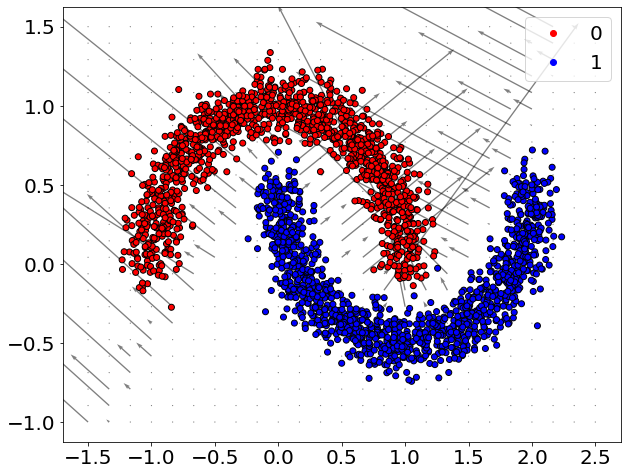

In [56]:
# create meshgrid
n = 25
a = th.linspace(-1.5, 2.5,  n)
b = th.linspace(-1., 1.5, n)
x = a.repeat(n)
y = b.repeat(n, 1).t().contiguous().view(-1)

x.requires_grad = True
y.requires_grad=True
z = net(th.stack([x, y], dim=-1)).softmax(-1)[:, 0]
# this line will compute the gradients
th.autograd.backward([z], [th.ones(x.size()), th.ones(y.size())])

# detach to plot
quiver = plt.quiver(x.detach(), y.detach(), x.grad, y.grad, color="black", alpha=.5)

scatter = plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap=cm_bright, edgecolors="k")

plt.legend(*scatter.legend_elements(), fontsize=20, loc="upper right")
plt.savefig("half_moons.pdf")

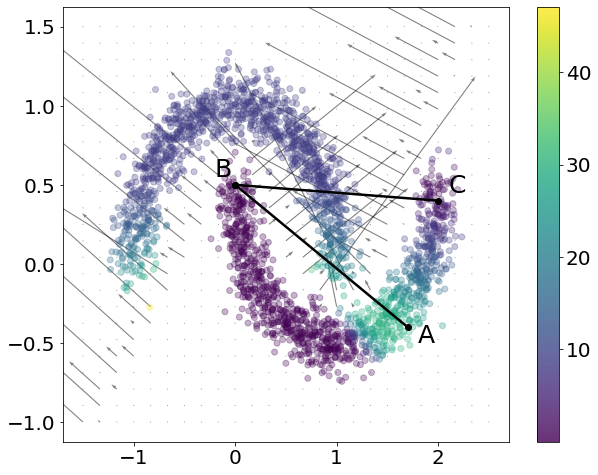

In [57]:
# create meshgrid
n = 25
a = th.linspace(-1.5, 2.5,  n)
b = th.linspace(-1., 1.5, n)
x = a.repeat(n)
y = b.repeat(n, 1).t().contiguous().view(-1)

x.requires_grad = True
y.requires_grad=True
z = net(th.stack([x, y], dim=-1)).softmax(-1)[:, 0]
# this line will compute the gradients
th.autograd.backward([z], [th.ones(x.size()), th.ones(y.size())])

# detach to plot
quiver = plt.quiver(x.detach(), y.detach(), x.grad, y.grad, color="black", alpha=.5)

scatter = plt.scatter(x_test[:, 0], x_test[:, 1], c=attr_ig.abs().sum(-1), alpha=.3)

plt.plot([0., 1.7], [0.5, -0.4], color='black', marker='o', linewidth=2.5)
plt.plot([0., 2.], [0.5, 0.4], color='black', marker='o', linewidth=2.5)

plt.text(-0.2, 0.55, "B", fontsize=25)
plt.text(1.8, -0.5, "A", fontsize=25)
plt.text(2.1, 0.45, "C", fontsize=25)

cbar = plt.colorbar(scatter)
cbar.set_alpha(.8)
cbar.draw_all()
cbar.ax.tick_params(labelsize=20)
# plt.quiverkey(quiver, 2.4, -1.0, -2, 'gradients', coordinates='data')
plt.savefig("integrated_gradients.pdf")

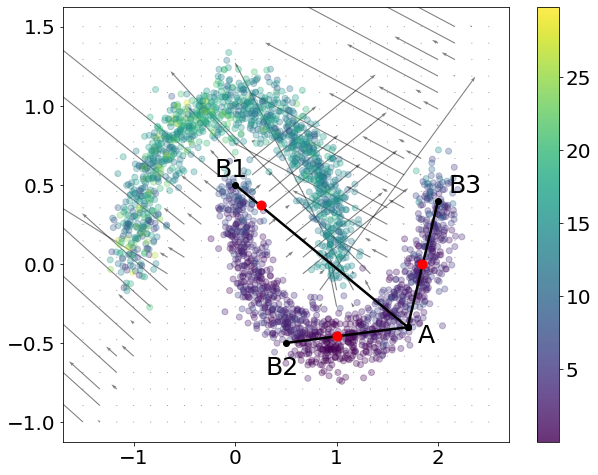

In [93]:
# create meshgrid
n = 25
a = th.linspace(-1.5, 2.5,  n)
b = th.linspace(-1., 1.5, n)
x = a.repeat(n)
y = b.repeat(n, 1).t().contiguous().view(-1)

x.requires_grad = True
y.requires_grad=True
z = net(th.stack([x, y], dim=-1)).softmax(-1)[:, 0]
# this line will compute the gradients
th.autograd.backward([z], [th.ones(x.size()), th.ones(y.size())])

# detach to plot
quiver = plt.quiver(x.detach(), y.detach(), x.grad, y.grad, color="black", alpha=.5)

scatter = plt.scatter(x_test[:, 0], x_test[:, 1], c=attr_gs.abs().sum(-1), alpha=.3)

plt.scatter(.25, .37, s=80, color="red", zorder=2)
plt.scatter(1., -0.455, s=80, color="red", zorder=2)
plt.scatter(1.845, 0., s=80, color="red", zorder=2)

plt.plot([1.7, 0.], [-0.4, 0.5], color='black', marker='o', linewidth=2.5, zorder=1)
plt.plot([1.7, 2.], [-0.4, 0.4], color='black', marker='o', linewidth=2.5, zorder=1)
plt.plot([1.7, 0.5], [-0.4, -0.5], color='black', marker='o', linewidth=2.5, zorder=1)

plt.text(1.8, -0.5, "A", fontsize=25)
plt.text(-0.2, 0.55, "B1", fontsize=25)
plt.text(0.3, -0.7, "B2", fontsize=25)
plt.text(2.1, 0.45, "B3", fontsize=25)

cbar = plt.colorbar(scatter)
cbar.set_alpha(.8)
cbar.draw_all()
cbar.ax.tick_params(labelsize=20)
# plt.quiverkey(quiver, 2.4, -1.0, -2, 'gradients', coordinates='data')
plt.savefig("gradients_shap.pdf")

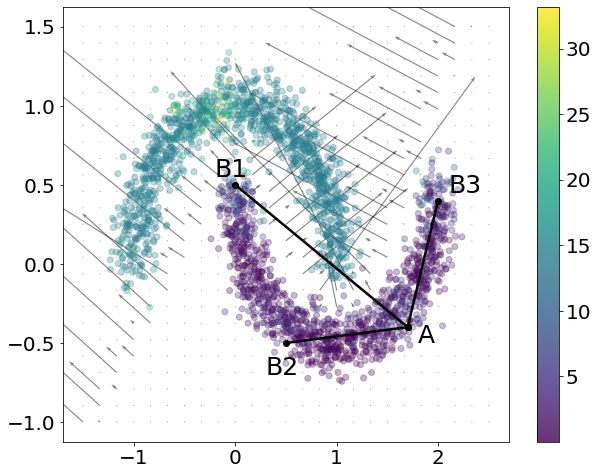

In [59]:
# create meshgrid
n = 25
a = th.linspace(-1.5, 2.5,  n)
b = th.linspace(-1., 1.5, n)
x = a.repeat(n)
y = b.repeat(n, 1).t().contiguous().view(-1)

x.requires_grad = True
y.requires_grad=True
z = net(th.stack([x, y], dim=-1)).softmax(-1)[:, 0]
# this line will compute the gradients
th.autograd.backward([z], [th.ones(x.size()), th.ones(y.size())])

# detach to plot
quiver = plt.quiver(x.detach(), y.detach(), x.grad, y.grad, color="black", alpha=.5)

scatter = plt.scatter(x_test[:, 0], x_test[:, 1], c=attr_nt.abs().sum(-1), alpha=.3)

plt.plot([1.7, 0.], [-0.4, 0.5], color='black', marker='o', linewidth=2.5)
plt.plot([1.7, 2.], [-0.4, 0.4], color='black', marker='o', linewidth=2.5)
plt.plot([1.7, 0.5], [-0.4, -0.5], color='black', marker='o', linewidth=2.5)

plt.text(1.8, -0.5, "A", fontsize=25)
plt.text(-0.2, 0.55, "B1", fontsize=25)
plt.text(0.3, -0.7, "B2", fontsize=25)
plt.text(2.1, 0.45, "B3", fontsize=25)

cbar = plt.colorbar(scatter)
cbar.set_alpha(.8)
cbar.draw_all()
cbar.ax.tick_params(labelsize=20)
# plt.quiverkey(quiver, 2.4, -1.0, -2, 'gradients', coordinates='data')
plt.savefig("smooth_grad.pdf")

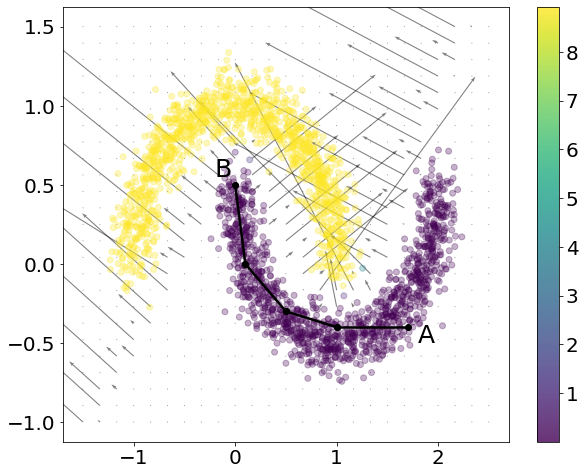

In [60]:
# create meshgrid
n = 25
a = th.linspace(-1.5, 2.5,  n)
b = th.linspace(-1., 1.5, n)
x = a.repeat(n)
y = b.repeat(n, 1).t().contiguous().view(-1)

x.requires_grad = True
y.requires_grad=True
z = net(th.stack([x, y], dim=-1)).softmax(-1)[:, 0]
# this line will compute the gradients
th.autograd.backward([z], [th.ones(x.size()), th.ones(y.size())])

# detach to plot
quiver = plt.quiver(x.detach(), y.detach(), x.grad, y.grad, color="black", alpha=.5)

scatter = plt.scatter(x_test[:, 0], x_test[:, 1], c=attr_gig.abs().sum(-1), alpha=.3)

plt.plot([0., 0.1], [0.5, 0.], color='black', marker='o', linewidth=2.5)
plt.plot([0.1, 0.5], [0., -0.3], color='black', marker='o', linewidth=2.5)
plt.plot([0.5, 1.], [-0.3, -0.4], color='black', marker='o', linewidth=2.5)
plt.plot([1., 1.7], [-0.4, -0.4], color='black', marker='o', linewidth=2.5)

plt.text(1.8, -0.5, "A", fontsize=25)
plt.text(-0.2, 0.55, "B", fontsize=25)

cbar = plt.colorbar(scatter)
cbar.set_alpha(.8)
cbar.draw_all()
cbar.ax.tick_params(labelsize=20)
# plt.quiverkey(quiver, 2.4, -1.0, -2, 'gradients', coordinates='data')
plt.savefig("geodesic_ig.pdf")

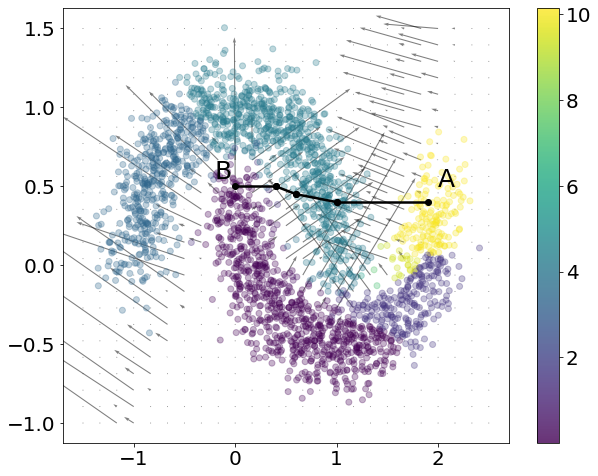

In [30]:
# create meshgrid
n = 25
a = th.linspace(-1.5, 2.5,  n)
b = th.linspace(-1., 1.5, n)
x = a.repeat(n)
y = b.repeat(n, 1).t().contiguous().view(-1)

x.requires_grad = True
y.requires_grad=True
z = net(th.stack([x, y], dim=-1)).softmax(-1)[:, 0]
# this line will compute the gradients
th.autograd.backward([z], [th.ones(x.size()), th.ones(y.size())])

# detach to plot
quiver = plt.quiver(x.detach(), y.detach(), x.grad, y.grad, color="black", alpha=.5)

scatter = plt.scatter(x_test[:, 0], x_test[:, 1], c=attr_enh.abs().sum(-1), alpha=.3)

plt.plot([0., 0.4], [0.5, 0.5], color='black', marker='o', linewidth=2.5)
plt.plot([0.4, 0.6], [0.5, 0.45], color='black', marker='o', linewidth=2.5)
plt.plot([0.6, 1.], [0.45, 0.4], color='black', marker='o', linewidth=2.5)
plt.plot([1., 1.9], [0.4, 0.4], color='black', marker='o', linewidth=2.5)

plt.text(2., 0.5, "A", fontsize=25)
plt.text(-0.2, 0.55, "B", fontsize=25)

cbar = plt.colorbar(scatter)
cbar.set_alpha(.8)
cbar.draw_all()
cbar.ax.tick_params(labelsize=20)
# plt.quiverkey(quiver, 2.4, -1.0, -2, 'gradients', coordinates='data')
plt.savefig("enhanced_ig.pdf")